In [1]:
import time

import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


,F,G,S
2012-01-04 00:00:00,-0.014730,0.005067,0.001569
2012-01-05 00:00:00,0.006770,0.006828,0.002662
2012-01-06 00:00:00,-0.014570,-0.003676,-0.002577
2012-01-09 00:00:00,0.021325,-0.004453,0.002427
2012-01-10 00:00:00,0.022550,0.013674,0.008671


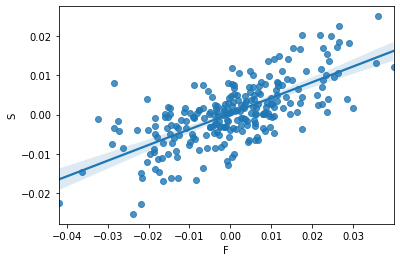

In [2]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df, v["ret"]] , axis = 1)
    
ret_df.columns = data.keys()
display(ret_df.head())
sns.regplot(x="F", y="S", data=ret_df)

observation_index_points_ =  ret_df["F"].values.reshape(-1,1)
observations_ = ret_df["S"].values

# 1. Construct Model

## 1.1 Define Model

In [10]:
def build_gp(amplitude, length_scale, observation_noise_variance):

    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})



## 1.2 Constraint Parameters

In [6]:
# Constraining parameters to positive
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]


## 1.3 Define log probability

In [7]:
# Define the log probability

@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

# 2. Train Model

## 2.1 Define the HMC sampler

In [8]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64),
        num_leapfrog_steps=8),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

## 2.2 Run the HMC Sampler

In [11]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, experimental_compile=False)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Inference ran in 16.83s.


## 2.3 Visualize trace of hyperparameters

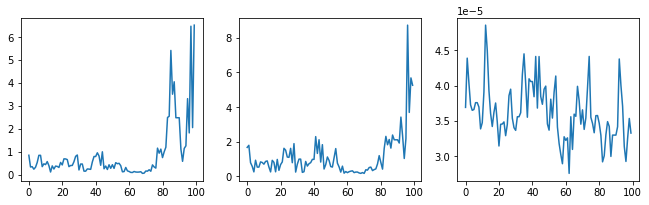

In [13]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
    ax = f.add_subplot(1, len(samples) + 1, i + 1)
    ax.plot(s)

# 3. Perform Predictions

In [15]:
predictive_index_points_ = np.linspace(np.min(observation_index_points_),np.max(observation_index_points_), 100 )
predictive_index_points_ = predictive_index_points_[..., np.newaxis]


batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(amplitude_samples, length_scale_samples)


batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

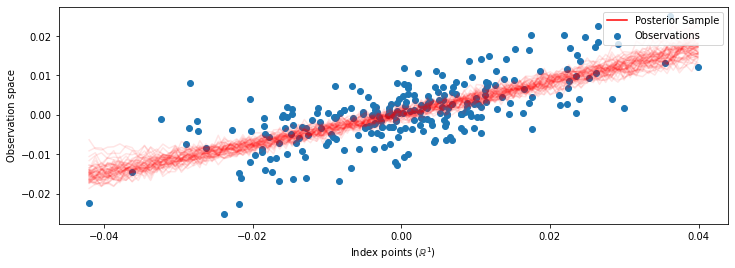

In [17]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.scatter(observation_index_points_[:, 0], observations_, label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
             label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()